In [1]:
from scipy import stats
import scikit_posthocs as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import humanize
import warnings
import pymongo
import os

In [2]:
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 80
warnings.filterwarnings('ignore')

In [3]:
client = pymongo.MongoClient(os.getenv('MONGO_URI'))
db = client[os.getenv('MONGO_DATABASE')]
collection = db['scrapy_bogota_apartments_processed']

apartments = pd.DataFrame(list(collection.find()))
apartments = apartments.drop(columns=['_id'], axis=1)
apartments = apartments.loc[(apartments['tipo_operacion'] == 'VENTA') & (apartments['coords_modified'] == False) & (apartments['area'] > 0)]

apartments.localidad.unique()

array(['USAQUEN', 'SUBA', 'CHAPINERO', 'TEUSAQUILLO', 'KENNEDY',
       'FONTIBON', 'ANTONIO NARINO', 'RAFAEL URIBE URIBE', 'SANTA FE',
       'BOSA', 'ENGATIVA', 'PUENTE ARANDA', 'LOS MARTIRES',
       'BARRIOS UNIDOS', 'CIUDAD BOLIVAR', 'CANDELARIA', 'SAN CRISTOBAL',
       'USME', 'TUNJUELITO'], dtype=object)

In [4]:
def delete_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    df = df[(df[column] >= q1 - 1.5 * iqr) & (df[column] <= q3 + 1.5 * iqr)]
    return df

In [5]:
fotmat_tick_humanize = lambda x, pos: humanize.intword(x)

In [6]:
chapinero = apartments.loc[apartments['localidad'] == 'CHAPINERO'].sample(1000, random_state=42)
usaquen = apartments.loc[apartments['localidad'] == 'USAQUEN'].sample(1000, random_state=42)
suba = apartments.loc[apartments['localidad'] == 'SUBA'].sample(1000, random_state=42)

chapinero = delete_outliers(chapinero, 'precio_venta')
usaquen = delete_outliers(usaquen, 'precio_venta')
suba = delete_outliers(suba, 'precio_venta')

chapinero = delete_outliers(chapinero, 'area')
usaquen = delete_outliers(usaquen, 'area')
suba = delete_outliers(suba, 'area')

## Precio de Venta de los apartamentos

Existe una diferencia significativa en el precio de venta de los apartamentos entre las 3 localidades(Chapinero, Usaquen y Suba)?

In [7]:
print(f'Chapinero: {chapinero.shape}')
print(f'Usaquen: {usaquen.shape}')
print(f'Suba: {suba.shape} \n')

print(f'Chapinero Median: {humanize.intcomma(chapinero.precio_venta.median())}')
print(f'Usaquen Median: {humanize.intcomma(usaquen.precio_venta.median())}')
print(f'Suba Median: {humanize.intcomma(suba.precio_venta.median())} \n')

print(f'Chapinero Mean: {humanize.intcomma(round(chapinero.precio_venta.mean()))}')
print(f'Usaquen Mean: {humanize.intcomma(round(usaquen.precio_venta.mean()))}')
print(f'Suba Mean: {humanize.intcomma(round(suba.precio_venta.mean()))} \n')

print(f'Chapinero Std: {humanize.intcomma(round(chapinero.precio_venta.std()))}')
print(f'Usaquen Std: {humanize.intcomma(round(usaquen.precio_venta.std()))}')
print(f'Suba Std: {humanize.intcomma(round(suba.precio_venta.std()))} \n')


Chapinero: (939, 40)
Usaquen: (914, 40)
Suba: (887, 40) 

Chapinero Median: 1,200,000,000.0
Usaquen Median: 590,000,000.0
Suba Median: 435,000,000.0 

Chapinero Mean: 1,375,295,537
Usaquen Mean: 715,259,596
Suba Mean: 463,706,509 

Chapinero Std: 829,571,899
Usaquen Std: 398,519,798
Suba Std: 211,482,775 



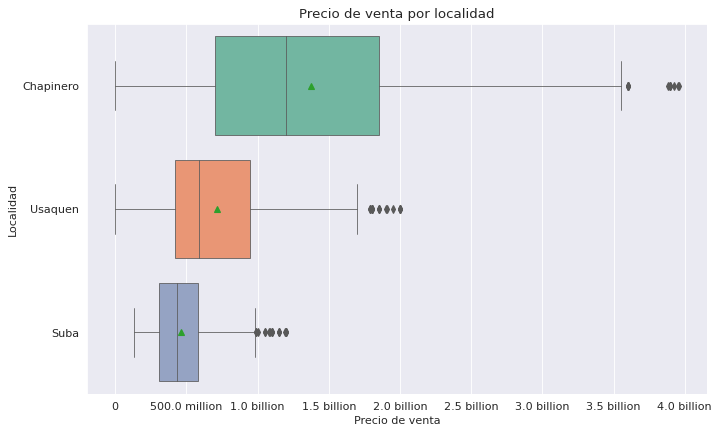

In [8]:
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=[chapinero.precio_venta, usaquen.precio_venta, suba.precio_venta],
    palette='Set2',
    orient='h',
    showmeans=True,
    linewidth=.7
)

plt.title('Precio de venta por localidad')
plt.xlabel('Precio de venta')
plt.ylabel('Localidad')
plt.yticks([0, 1, 2], ['Chapinero', 'Usaquen', 'Suba'])
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.show()

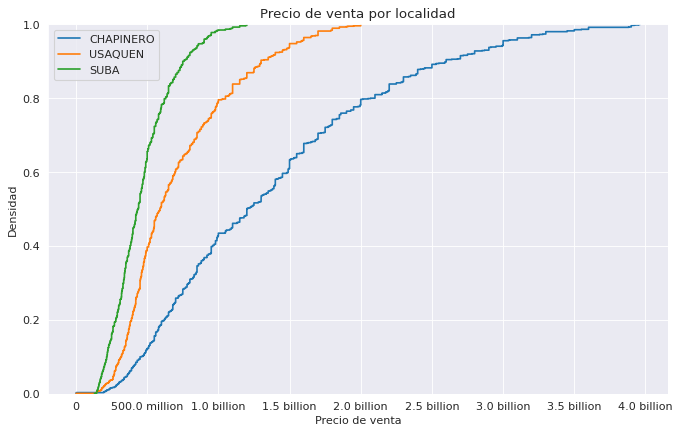

In [9]:
plt.figure(figsize=(10, 6))

for df in [chapinero, usaquen, suba]:
    sns.ecdfplot(df.precio_venta, label=df.localidad.iloc[0])

plt.title('Precio de venta por localidad')
plt.xlabel('Precio de venta')
plt.ylabel('Densidad')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.legend()
plt.show()

Localidad: CHAPINERO
p-value: 6.574599902388356e-19
Is normal: False 

Localidad: USAQUEN
p-value: 3.465035907348948e-27
Is normal: False 

Localidad: SUBA
p-value: 4.174315255363215e-21
Is normal: False 



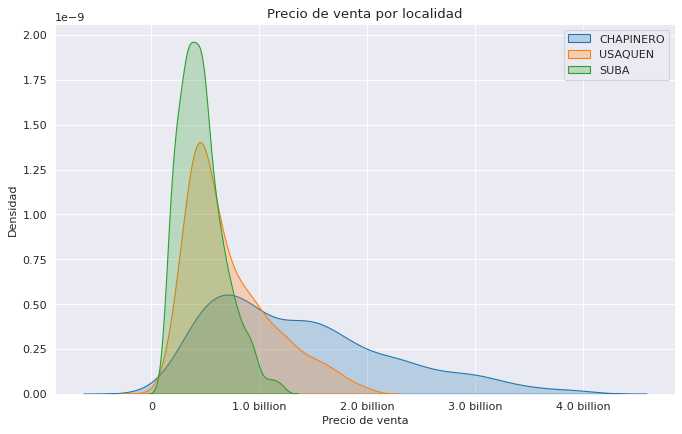

In [10]:
for df in [chapinero, usaquen, suba]:
    res = stats.normaltest(df.precio_venta)
    print(f'Localidad: {df.localidad.iloc[0]}')
    print(f'p-value: {res.pvalue}')
    print(f'Is normal: {res.pvalue > 0.05} \n')

plt.figure(figsize=(10, 6))

for df in [chapinero, usaquen, suba]:
    sns.kdeplot(df.precio_venta, label=df.localidad.iloc[0], fill=True)

plt.title('Precio de venta por localidad')
plt.xlabel('Precio de venta')
plt.ylabel('Densidad')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.legend()
plt.show()

**H0:** No existe una diferencia significativa entre los precios de venta de los apartamentos en las 3 localidades.

**H1:** Existe una diferencia significativa entre los precios de venta de los apartamentos en las 3 localidades.

In [11]:
_, pvalue = stats.kruskal(chapinero.precio_venta.values, usaquen.precio_venta.values, suba.precio_venta.values)
print(f'p-value: {pvalue}')

if pvalue < 0.05:
    print('Reject null hypothesis (H0)')
else:
    print('Accept null hypothesis (H0)')

p-value: 4.661953432081803e-199
Reject null hypothesis (H0)


In [12]:
data = pd.DataFrame({
    'precio_venta': np.concatenate([chapinero.precio_venta.values, usaquen.precio_venta.values, suba.precio_venta.values]),
    'localidad': np.concatenate([chapinero.localidad.values, usaquen.localidad.values, suba.localidad.values])
})

data['localidad'] = data['localidad'].astype('category')
# data['localidad'] = data['localidad'].cat.codes

posthoc = sp.posthoc_dunn(data, val_col='precio_venta', group_col='localidad')
posthoc

,CHAPINERO,SUBA,USAQUEN
CHAPINERO,1.000000e+00,2.192256e-198,1.094156e-68
SUBA,2.192256e-198,1.000000e+00,2.562066e-36
USAQUEN,1.094156e-68,2.562066e-36,1.000000e+00


In [13]:
print('Chapinero - Usaquen' if posthoc.iloc[0, 1] < 0.05 else 'Chapinero - Usaquen: No hay diferencia significativa')
print('Chapinero - Suba' if posthoc.iloc[0, 2] < 0.05 else 'Chapinero - Suba: No hay diferencia significativa')
print('Usaquen - Suba' if posthoc.iloc[1, 2] < 0.05 else 'Usaquen - Suba: No hay diferencia significativa')

Chapinero - Usaquen
Chapinero - Suba
Usaquen - Suba


## Tamaño de los apartamentos

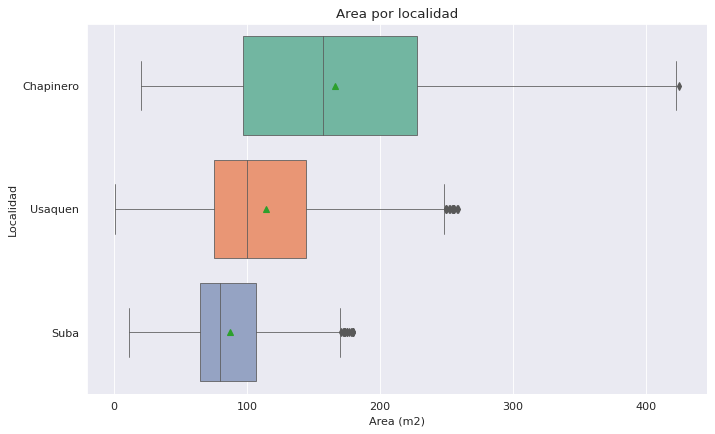

In [14]:
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=[chapinero.area, usaquen.area, suba.area],
    palette='Set2',
    orient='h',
    showmeans=True,
    linewidth=.7
)

plt.title('Area por localidad')
plt.xlabel('Area (m2)')
plt.ylabel('Localidad')
plt.yticks([0, 1, 2], ['Chapinero', 'Usaquen', 'Suba'])
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.show()

Localidad: CHAPINERO
p-value: 1.9676551204589493e-10
Is normal: False 

Localidad: USAQUEN
p-value: 2.32435172189958e-18
Is normal: False 

Localidad: SUBA
p-value: 6.40940291014208e-14
Is normal: False 



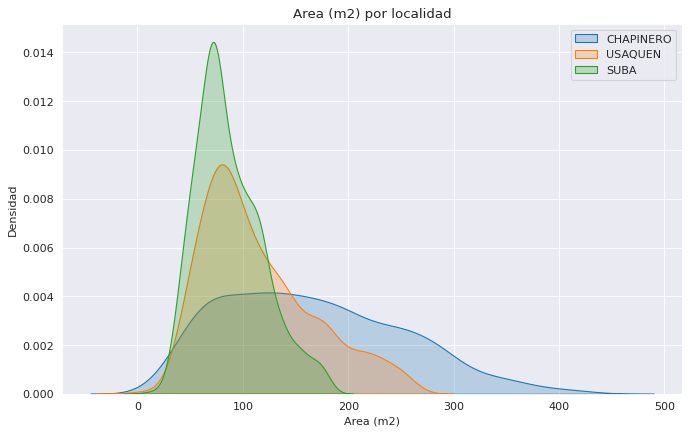

In [15]:
for df in [chapinero, usaquen, suba]:
    res = stats.normaltest(df.area)
    print(f'Localidad: {df.localidad.iloc[0]}')
    print(f'p-value: {res.pvalue}')
    print(f'Is normal: {res.pvalue > 0.05} \n')

plt.figure(figsize=(10, 6))

for df in [chapinero, usaquen, suba]:
    sns.kdeplot(df.area, label=df.localidad.iloc[0], fill=True)

plt.title('Area (m2) por localidad')
plt.xlabel('Area (m2)')
plt.ylabel('Densidad')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.legend()
plt.show()

**H0:** No existe una diferencia significativa entre los tamaños de los apartamentos en las 3 localidades.

**H1:** Existe una diferencia significativa entre los tamaños de los apartamentos en las 3 localidades.

In [16]:
_, pvalue = stats.kruskal(chapinero.area.values, usaquen.area.values, suba.area.values)
print(f'p-value: {pvalue}')

if pvalue < 0.05:
    print('Reject null hypothesis (H0)')

p-value: 9.465632997864561e-109
Reject null hypothesis (H0)


In [17]:
data = pd.DataFrame({
    'area': np.concatenate([chapinero.area.values, usaquen.area.values, suba.area.values]),
    'localidad': np.concatenate([chapinero.localidad.values, usaquen.localidad.values, suba.localidad.values])
})

data['localidad'] = data['localidad'].astype('category')
# data['localidad'] = data['localidad'].cat.codes

posthoc = sp.posthoc_dunn(data, val_col='area', group_col='localidad')
posthoc

,CHAPINERO,SUBA,USAQUEN
CHAPINERO,1.000000e+00,1.963609e-109,6.315645e-36
SUBA,1.963609e-109,1.000000e+00,1.981580e-22
USAQUEN,6.315645e-36,1.981580e-22,1.000000e+00


In [21]:
print('Chapinero - Usaquen' if posthoc.iloc[0, 1] < 0.05 else 'Chapinero - Usaquen: No hay diferencia significativa')
print('Chapinero - Suba' if posthoc.iloc[0, 2] < 0.05 else 'Chapinero - Suba: No hay diferencia significativa')
print('Usaquen - Suba' if posthoc.iloc[1, 2] < 0.05 else 'Usaquen - Suba: No hay diferencia significativa')

Chapinero - Usaquen
Chapinero - Suba
Usaquen - Suba
